In [15]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

file_path ="../data/seeds_dataset.txt"

# 데이터 열 이름 예시 (실제 데이터에 맞게 조정 필요)
column_names = ['a','p','c','length of kernel', 'width of kernel', 'asymmetry coefficient','length of kernel groove','class']

df = pd.read_csv(file_path,delim_whitespace=True,header=None,names=column_names)
df

,a,p,c,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,class
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1
...,...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3


In [16]:
# 결측치 확인
df.isnull().sum()

a                          0
p                          0
c                          0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
class                      0
dtype: int64

In [17]:
df['class'].value_counts()

class
1    70
2    70
3    70
Name: count, dtype: int64

In [18]:
# 입력 변수(X)와 출력 변수(y) 분리
X = df.drop('class', axis=1)
y = df['class'] - 1  # 클래스 레이블을 0부터 시작하도록 조정

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

In [20]:

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# One-hot 인코딩
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

# TensorFlow 데이터셋 생성
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train_categorical))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test_categorical))

In [21]:
# 배치 크기 설정 및 셔플
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# 입력 레이어 정의
inputs = tf.keras.Input(shape=(X_train_scaled.shape[1],))  # 입력 데이터의 특성 수

# Dense 레이어 체인
x = tf.keras.layers.Dense(16, activation='relu')(inputs)
x = tf.keras.layers.Dropout(0.5)(x)  # 드롭아웃 추가
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)  # 드롭아웃 추가
# 출력 레이어
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)  # 클래스 수에 맞게 유닛 수 설정


In [24]:
from tensorflow.keras.callbacks import EarlyStopping
# 모델 생성
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 조기 종료 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 요약 출력
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense_3 (Dense)             (None, 16)                128       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                 51        
                                                                 
Total params: 451
Trainable params: 451
Non-trainable param

In [26]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
# 모델 훈련
history = model.fit(train_dataset, epochs=50, validation_data=test_dataset, callbacks=[early_stopping])

# 모델 평가
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Accuracy: {test_accuracy:.4f}')

# 예측
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)

# 성능 지표 출력
print("Classification Report:")
print(classification_report(np.argmax(y_test_categorical, axis=1), y_pred_classes))
print("Confusion Matrix:")
print(confusion_matrix(np.argmax(y_test_categorical, axis=1), y_pred_classes))

Epoch 1/50
5/5 [==============================] - 0s 4ms/step - loss: 0.6396 - accuracy: 0.7211 - val_loss: 0.3821 - val_accuracy: 0.9206
Epoch 2/50
5/5 [==============================] - 0s 4ms/step - loss: 0.6103 - accuracy: 0.7347 - val_loss: 0.3769 - val_accuracy: 0.9206
Epoch 3/50
5/5 [==============================] - 0s 4ms/step - loss: 0.5989 - accuracy: 0.7347 - val_loss: 0.3719 - val_accuracy: 0.9206
Epoch 4/50
5/5 [==============================] - 0s 3ms/step - loss: 0.6703 - accuracy: 0.7347 - val_loss: 0.3680 - val_accuracy: 0.9206
Epoch 5/50
5/5 [==============================] - 0s 3ms/step - loss: 0.5945 - accuracy: 0.7279 - val_loss: 0.3641 - val_accuracy: 0.9206
Epoch 6/50
5/5 [==============================] - 0s 3ms/step - loss: 0.5295 - accuracy: 0.7551 - val_loss: 0.3596 - val_accuracy: 0.9206
Epoch 7/50
5/5 [==============================] - 0s 2ms/step - loss: 0.5877 - accuracy: 0.7415 - val_loss: 0.3543 - val_accuracy: 0.9206
Epoch 8/50
5/5 [==================

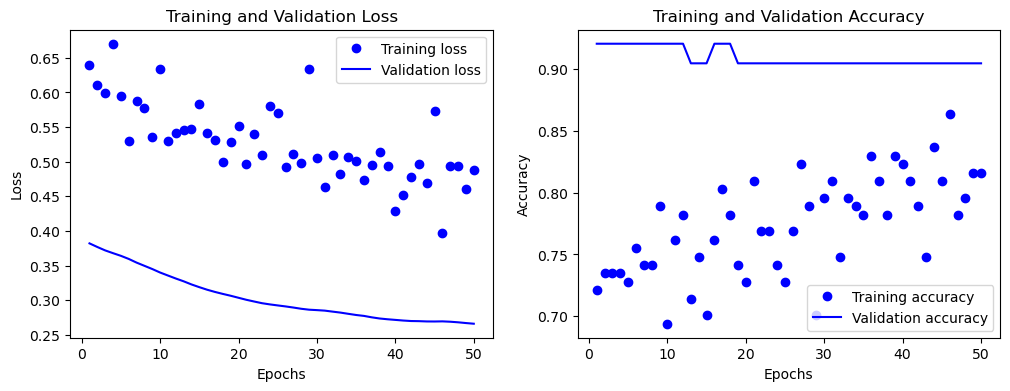

In [27]:
# 훈련 데이터의 손실값과 검증 데이터의 손실값을 그래프에 출력
history_dict = history.history
loss_values = history_dict['loss']  # 훈련 데이터 손실값
val_loss_values = history_dict['val_loss']  # 검증 데이터 손실값
acc = history_dict['accuracy']      # 훈련 정확도
val_acc = history_dict['val_accuracy']  # 검증 정확도
epochs = range(1, len(acc) + 1)     # 에포크 수

plt.figure(figsize=(12, 4))

# 손실값 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()